In [1]:
%matplotlib inline
import pylab
import pandas as pd

## load mapping summary CSVs and gather CSV

In [2]:
sample_id = 'p8808mo11'

# load mapping CSVs
all_df = pd.read_csv(f'outputs/minimap/depth/{sample_id}.summary.csv')
left_df = pd.read_csv(f'outputs/leftover/depth/{sample_id}.summary.csv')

# load gather CSV
gather_df = pd.read_csv(f'outputs/{sample_id}.gather.csv')

# connect gather_df to all_df and left_df using 'genome_id'
def fix_name(x):
    return "_".join(x.split('_')[:2]).split('.')[0]

gather_df['genome_id'] = gather_df['name'].apply(fix_name)

In [3]:
# CTB bug FIXME
# this ensures that only rows that share genome_id are in all the dataframes
in_gather = set(gather_df.genome_id)
in_left = set(left_df.genome_id)

in_both = in_left.intersection(in_gather)

all_df = all_df[all_df.genome_id.isin(in_both)]
left_df = left_df[left_df.genome_id.isin(in_both)]
gather_df = gather_df[gather_df.genome_id.isin(in_both)]

# reassign index now that we've maybe dropped rows
all_df.index = range(len(all_df))
left_df.index = range(len(left_df))
gather_df.index = range(len(gather_df))

assert len(all_df) == len(gather_df)
assert len(left_df) == len(gather_df)

In [4]:
# re-sort left_df and all_df to match gather_df order, using matching genome_id column
all_df.set_index("genome_id")
all_df.reindex(index=gather_df["genome_id"])
all_df.reset_index()
all_df[:3]

left_df.set_index("genome_id")
left_df.reindex(index=gather_df["genome_id"])
left_df.reset_index()
left_df[:3]

left_df["mapped_bp"] = (1 - left_df["percent missed"]/100) * left_df["genome bp"]

In [5]:
left_df[:5]

,Unnamed: 0,genome bp,missed,percent missed,coverage,genome_id,sample_id,mapped_bp
0,GCA_010669205,6197116,485328,7.831514,25.055397,GCA_010669205,p8808mo11,5711788.0
1,GCA_000433395,5587080,13274,0.237584,15.577709,GCA_000433395,p8808mo11,5573806.0
2,GCA_012980095,5179284,101518,1.960078,48.870363,GCA_012980095,p8808mo11,5077766.0
3,GCA_001405335,5514222,565988,10.264150,37.890901,GCA_001405335,p8808mo11,4948234.0
4,GCA_000189615,4916964,361174,7.345468,18.913976,GCA_000189615,p8808mo11,4555790.0


In [6]:
gather_df[:5]

,intersect_bp,f_orig_query,f_match,f_unique_to_query,f_unique_weighted,average_abund,median_abund,std_abund,name,filename,md5,f_match_orig,unique_intersect_bp,gather_result_rank,remaining_bp,genome_id
0,5634000,0.019827,0.917291,0.019827,0.033343,17.335108,15.0,61.941587,GCA_010669205.1_ASM1066920v1_genomic.fna.gz,all-gather-genomes.sbt.zip,698994c96972a3ff39d5abbef995fbd9,0.917291,5634000,0,278527000,GCA_010669205
1,5510000,0.019390,0.996023,0.019390,0.018763,9.974410,9.0,5.981056,GCA_000433395.1_MGS224_genomic.fna.gz,all-gather-genomes.sbt.zip,e1681d164e1343664cc157db62bef9ea,0.996023,5510000,1,273017000,GCA_000433395
2,5015000,0.017648,0.981601,0.017648,0.059578,34.797807,30.0,45.273493,GCA_012980095.1_PDT000632230.1_genomic.fna.gz,all-gather-genomes.sbt.zip,bb4ad2a307756042bba9542f947e6593,0.981601,5015000,2,268002000,GCA_012980095
3,4586000,0.016139,0.836494,0.015987,0.044380,28.614572,24.0,37.731637,GCA_001405335.1_13470_2_84_genomic.fna.gz,all-gather-genomes.sbt.zip,fc9e495736d6619bad52fa69cede71dc,0.844412,4543000,3,263459000,GCA_001405335
4,4168000,0.014668,0.683347,0.014513,0.007188,5.105238,4.0,23.697292,GCA_003434055.1_ASM343405v1_genomic.fna.gz,all-gather-genomes.sbt.zip,420d475a10a0d7f2dd3f44da9d2fe498,0.690638,4124000,4,259335000,GCA_003434055


## fig 1: examining leftover reads, in order of gather

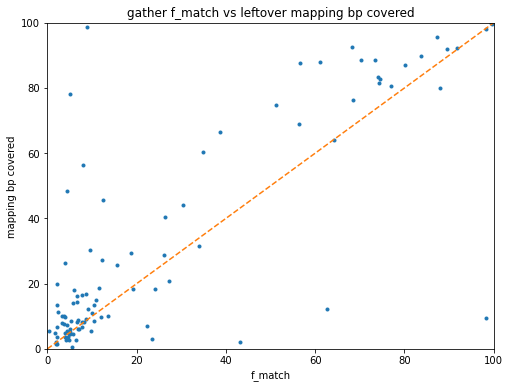

In [7]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(gather_df["f_match"]* 100, 100 - left_df["percent missed"], '.')

pylab.xlim(0, 100)
pylab.ylim(0, 100)
pylab.xlabel('f_match')
pylab.ylabel('mapping bp covered')
pylab.title('gather f_match vs leftover mapping bp covered')
pylab.plot([0, 100], [0, 100], '--')

## fig 2: fraction of hashes unique to query, in order of gather results

Text(0, 0.5, 'f_unique_to_query, as %')

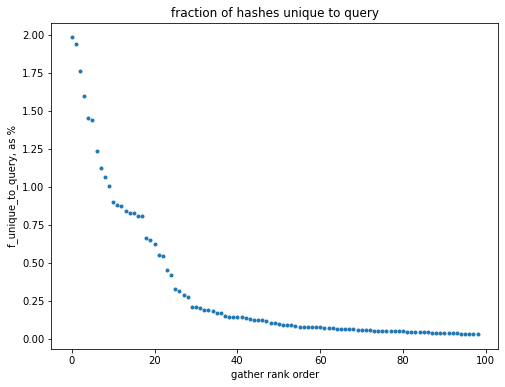

In [8]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(gather_df.index, gather_df["f_unique_to_query"]*100, '.')

pylab.title('fraction of hashes unique to query')
pylab.xlabel('gather rank order')
pylab.ylabel('f_unique_to_query, as %')

## fig 4: sum mapped bp and sum identified hashes, in order of gather

conclusion: across the gather run, total hashes identified correlate well with total bp mapped

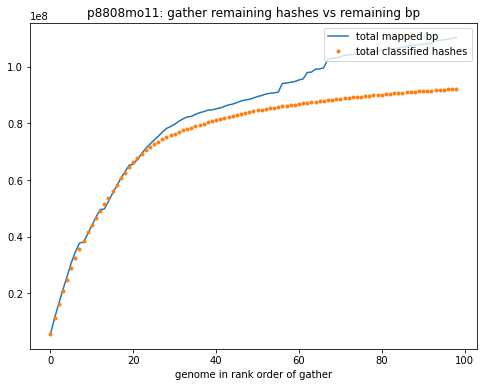

In [9]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(left_df.index, left_df["mapped_bp"].cumsum(), '-', label='total mapped bp')
pylab.plot(gather_df.index, gather_df["unique_intersect_bp"].cumsum(), '.', label='total classified hashes')

pylab.xlabel('genome in rank order of gather')
pylab.legend(loc='upper right')
pylab.title(f'{sample_id}: gather remaining hashes vs remaining bp')
pylab.savefig(f'/tmp/gather-{sample_id}.pdf')

## fig 5: mapped bp and identified hashes compared by sample, in order of gather

conclusion: for most samples, bp mapped to that genome matches # of hashes classified to that genome

note: hashes classified to this genome is monotonically decreasing, b/c gather is a greedy algorithm.

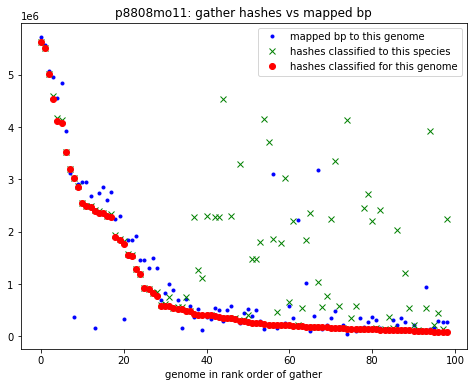

In [10]:
pylab.figure(num=None, figsize=(8, 6))

pylab.plot(left_df.index, left_df.mapped_bp, 'b.', label='mapped bp to this genome')
pylab.plot(gather_df.index, gather_df.intersect_bp, 'gx', label='hashes classified to this species')
pylab.plot(gather_df.index, gather_df.unique_intersect_bp, 'ro', label='hashes classified for this genome')

pylab.xlabel('genome in rank order of gather')
pylab.legend(loc='upper right')
pylab.title(f'{sample_id}: gather hashes vs mapped bp')
pylab.savefig(f'/tmp/gather-{sample_id}.pdf')

## fig 6: difference between hashes ident and bp mapped

Text(0, 0.5, 'difference: hashcount - mapped bp')

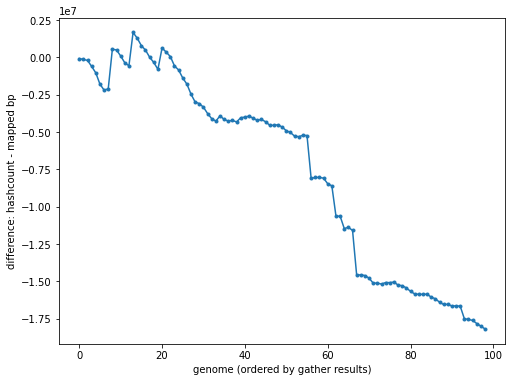

In [11]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(gather_df.index, gather_df.unique_intersect_bp.cumsum() - left_df.mapped_bp.cumsum(), '.-')

pylab.xlabel('genome (ordered by gather results)')
pylab.ylabel('difference: hashcount - mapped bp')

## fig 7: difference between hashes and bp, per sample

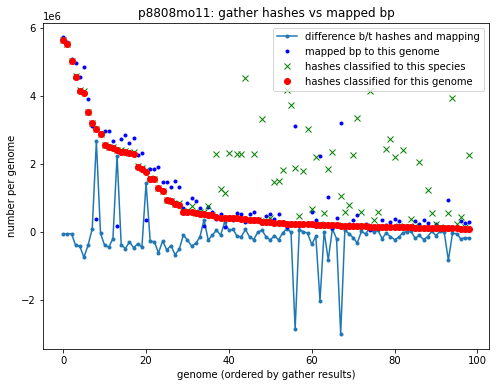

In [12]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(gather_df.index, gather_df.unique_intersect_bp - left_df.mapped_bp, '.-', label='difference b/t hashes and mapping')

pylab.plot(left_df.index, left_df.mapped_bp, 'b.', label='mapped bp to this genome')
pylab.plot(gather_df.index, gather_df.intersect_bp, 'gx', label='hashes classified to this species')
pylab.plot(gather_df.index, gather_df.unique_intersect_bp, 'ro', label='hashes classified for this genome')

pylab.xlabel('genome (ordered by gather results)')
pylab.ylabel('number per genome')
pylab.legend(loc='upper right')
pylab.title(f'{sample_id}: gather hashes vs mapped bp')
pylab.savefig(f'/tmp/gatherdiff-{sample_id}.pdf')
pylab.savefig(f'/tmp/gatherdiff-{sample_id}.svg')